# Homework Solution 1

Ming Hong (mh4286@nyu.edu)

In [1]:
%pylab inline

import sympy as sp
import pdb
import matplotlib.pyplot as plt
import pandas as pd
import time

Populating the interactive namespace from numpy and matplotlib


## Problem 1:

Set up your Python and IPython notebook environment and show case the following IPython functionalities:

1. use ? or help() to show comments (docstring) of a python function
2. use %pdb to debug the following code, show how to print out the value of b inside function bug() using the debugger

### Solution 1.1

In [2]:
# Comments will show up in a separate window at the bottom of the screen
?len()

### Solution 1.2

In [3]:
def div(a, b):
    return a/b

def bug(a, b):
    pdb.set_trace()
    return div(a, b)

bug(3,0)

# enter "p b" on the (Pdb) prompt to print the value of b inside bug()

> <ipython-input-3-c771a2ff08dc>(6)bug()
-> return div(a, b)
(Pdb) p b
0
(Pdb) c


ZeroDivisionError: integer division or modulo by zero

## Problem 2:

For the first term of the conditional variance expression of the CIR process discused in the class:

$$f(\kappa) = \frac{r_0\sigma^2}{\kappa}(e^{-\kappa t} - e^{-2\kappa t})$$

1. compute its condition number, assuming $\kappa$ is the only variable, comment on whether the computation is stable around $\kappa = 0$
2. implement a function to compute the above expression, which is numerically stable around $\kappa = 0$. A typical approach is to switch to an approximation when $\kappa$ is smaller than a threshold $h$. Explain your choice of $h$, is the $h$ different for double of single precision calculation?  

### Solution 2

1. Assuming $\kappa$ is the only variable, the condition number for $f(\kappa)$ is:

    $$ \begin{split} c & = \left|\frac{\kappa}{f} \cdot \frac{\partial f}{\partial\kappa}\right| = \left|\frac{\kappa^2}{r_0 \sigma^2 (e^{-\kappa t} - e^{-2\kappa t})} \cdot \frac{r_0 \sigma^2 [( -t e^{-\kappa t} + 2t e^{-2\kappa t} ) \kappa-(e^{-\kappa t} - e^{-2\kappa t})]} {\kappa^2}\right| \\ 
& = \left|\frac{2 \kappa t - e^{\kappa t}(\kappa t + 1) + 1}{e^{\kappa t}-1}\right| \end{split}$$

    Therefore, we have $\lim_{\kappa\to0} c = 0$ by l'Hopital's Rule, and the problem is well-posed around $\kappa = 0$. However, the computation is still unstable, as illustrated in the plots below.

2. Using Taylor's expansion, $f(\kappa)$ around $\kappa_0=0$ can be approximated, up to the 2nd order, as:

    $$ \begin{split} f(\kappa) & \approx f(0) + f'(0) \kappa + \frac{f''(0)}{2!} \kappa^2 \\
    & = r_0 \sigma^2 t (1- \frac{3}{2} t \kappa + \frac{7}{6} t^2 \kappa^2) \end{split}$$

    A threshold $h$ is selected empirically so that the approximation $g(\kappa)$ is more stable for $-h<\kappa<h$, and is equal to $f(\kappa)$ elsewhere. Namely,
    
    $$ g(\kappa) = \begin{cases}
                   r_0 \sigma^2 t (1- \frac{3}{2} t \kappa + \frac{7}{6} t^2 \kappa^2), & \text{if } -h<\kappa<h\\
                   f(\kappa), & \text{otherwise}
                   \end{cases} $$
    
    The approximations below are computed assuming $r_0=\sigma^2=t=1$ for simplicity, in double and single precision, respectively. $h = 2\times10^{-14}$ is used for double precision, and $h = 2\times10^{-5}$ for single precision.

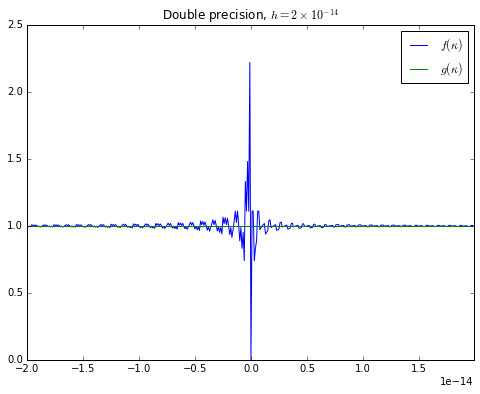

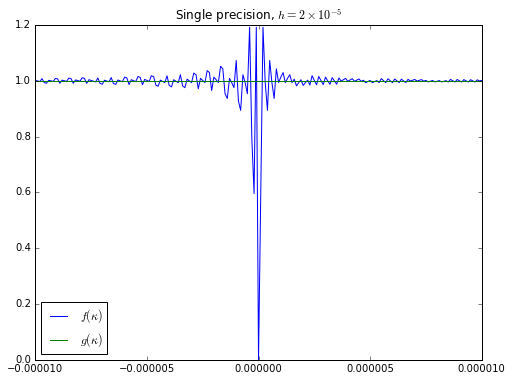

In [4]:
def f(k):
    r = 1
    sig2 = 1
    t = 1
    return r*sig2/k*(np.exp(-k*t)-np.exp(-2*k*t))

def g(k, h):
    ans = np.zeros_like(k)
    r = 1
    sig2 = 1
    t = 1
    G = (k>-h) & (k<h)
    F = np.ones(len(k),dtype=bool)
    F[G] = False
    ans[F] = f(k[F])
    ans[G] = 1-1.5*r*sig2*t**2*k[G]+7/6.*r*sig2*t**3*k[G]**2
    return ans

# double precision
k = np.arange(-20e-8, 20e-8, 1e-9)*1e-7
df = pd.DataFrame(np.array([f(k),g(k,2e-14)]).T, index=k, columns=[r'$f(\kappa)$', r'$g(\kappa)$'])
df.plot(title=r'Double precision, $h = 2\times10^{-14}$',figsize=(8,6))

# single precision
k_s = np.float32(np.arange(-1e-5,1e-5,1e-7))
df_s = pd.DataFrame(np.array([f(k_s),g(k_s,2e-5)]).T, index=k_s, columns=[r'$f(\kappa)$', r'$g(\kappa)$'])
df_s.plot(title=r'Single precision, $h = 2\times10^{-5}$',figsize=(8,6))

plt.show()

## Problem 3:

Implement a matrix product function using hand coded loops in python, please feel free to use numpy array and numpy vector multiplications, but obviously you should not just call numpy matrix multiplication.

Compare the speed of your implementation to the numpy matrix product version, plot the difference in computational time with the size of the matrix.


Hint: 

* %timeit is a useful timing tool in IPython, or you can use time.clock() function
* numpy has two ways of representing matrix, one is array of arrays, another is matrix type. For array types, the matrix production is ```a.dot(b)```, for matrix type, the matrix production is ```a*b```. We recommend you to stick with array type to avoid any potential confusions. The ```a*b``` on array type is element wise multiplication. A common mistake is use ```a*b``` for matrix production on array type. Please see the following code section as an example.
* numpy.allclose is a useful funciton to compare floating point calculation results


In [ ]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = a + 1
print "a=\n", a 
print "\nb=\n", b
c = a.dot(b) # matrix product
d = a*b #elment wise multiplication

print "\nc=a.dot(b)\n", c
print "\nd=a*b\n", d

### Solution 3

In [5]:
def matrix_prod(a,b):
    ans = np.zeros((int(a.shape[0]),int(b.shape[1])))
    if not(isinstance(a,np.ndarray) & isinstance(b,np.ndarray)):
        raise TypeError('arguments are not of numpy.ndarray type')
    if a.shape[1] != b.shape[0]:
        raise ValueError('dimensions of the two matrices do not match')
    for i,x in enumerate(a):
        for j,y in enumerate(b.T):
            ans[i,j] = np.dot(x,y)
    return ans

a = np.array([[1.5,2,3],[2.2,3,4]])
b = np.array([[3,2.9],[-1,2],[-3.2,4]])

t0 = time.clock()
ans1 = matrix_prod(a,b)
t1 = time.clock()
ans2 = a.dot(b)
t2 = time.clock()

print 'Answer 1\n', ans1
print '\nAnswer 2\n', ans2
print('\nNew implementation took %f.' % float(t1-t0))
print('Built-in implementation took %f.' % float(t2-t1))

print('Are the answers the same? %s.' % np.allclose(ans1, ans2))

Answer 1
[[ -7.1   20.35]
 [ -9.2   28.38]]

Answer 2
[[ -7.1   20.35]
 [ -9.2   28.38]]

New implementation took 0.000111.
Built-in implementation took 0.000077.
Are the answers the same? True.


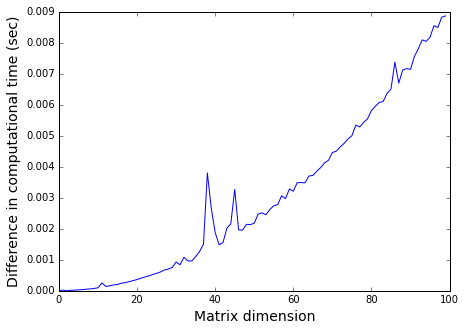

In [14]:
t = np.zeros(100)
for i in range(1,100,1):
    a = np.random.rand(i,i)
    b = np.random.rand(i,i)
    t0 = time.clock()
    ans1 = matrix_prod(a,b)
    t1 = time.clock()
    ans2 = a.dot(b)
    t2 = time.clock()
    
    t[i] = (t1-t0)-(t2-t1) # New minus built-in

plt.figure(figsize=(7,5))
plt.plot(range(100),t)
plt.xlabel('Matrix dimension',fontsize=14)
plt.ylabel('Difference in computational time (sec)',fontsize=14)
plt.show()

*Note: The curve would be much smoother if plotted in an IDE.*

## Book problems

Hint: 

* The extra credit part of this problem is rather involved, you are encouraged to try but there is no need to spend too much time.
* In python, floating point numbers are double precision by default, but you can force them to be single precision by calling numpy.float32, please see the following example:

In [ ]:
a = np.float32(1.)
b = np.float64(1.)

print type(a), type(b)

### Solution to Problem 2.8

#### Part (a)
$f_n$ and $p_n$ are plotted in the following log scale plot up to $n=85$. 

($\epsilon_{mach} = 2\times10^{-24}$ for single precision, and $\epsilon_{mach} = 2\times10^{-53}$ for double precision)

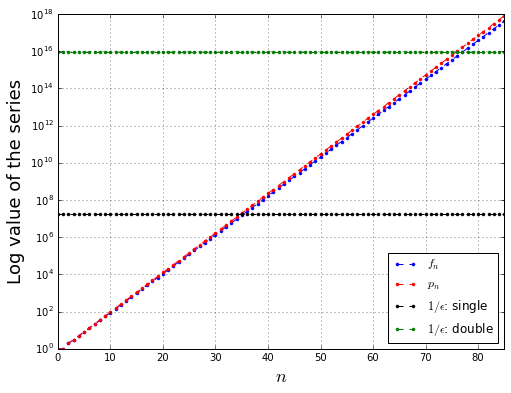

In [17]:
def fib(n):
    i = 1
    n = int(n)
    if n < 0:
        raise ValueError('n must be a non-negative integer')
    f = np.ones(n+1)
    a,b = 1,1
    for i in range(1,n+1):
        a,b = b, a+b
        f[i]=a
    return f


def pib(n):
    c = 1 + np.sqrt(3)/100
    i = 1
    n = int(n)
    if n < 0:
        raise ValueError('n must be a non-negative integer')
    if n == 0:
        p = [1]
    elif n > 0:
        p = [1,1]
        while i < n:
            p.append(c*p[i]+p[i-1])
            i += 1
    return p

n = 85
single = 1/2**(-24)*np.ones(n+1)
double = 1/2**(-53)*np.ones(n+1)
x=np.arange(0,n+1,1)

df = pd.DataFrame(np.array([fib(n),pib(n), single, double]).T, index=x, 
                  columns=[r'$f_n$', r'$p_n$',r'$1/\epsilon$: single',r'$1/\epsilon$: double'])
ax = df.plot(logy=True,style=['.--b','.--r','.--k','.--g'],markersize=6,grid=True,figsize=(8,6))
ax.set_ylabel('Log value of the series',fontsize=18)
ax.set_xlabel(r'$n$',fontsize=18)
plt.show()

As can be seen, the two series pass the single-precision threshold $1/\epsilon_{mach}$ at $p_{35}$ and $f_{36}$, and pass the double-precision one at $p_{76}$ and $f_{78}$, respectively. 

#### Part (b)

The reversed *fibonacci* series is calculated for $n$ from 2 to 100, and the absolute difference bdtween $f_0 = 1$ and $\hat{f_0}$ is plotted on log scale as a function of $n$. The calculations are done in both single and double precisions.

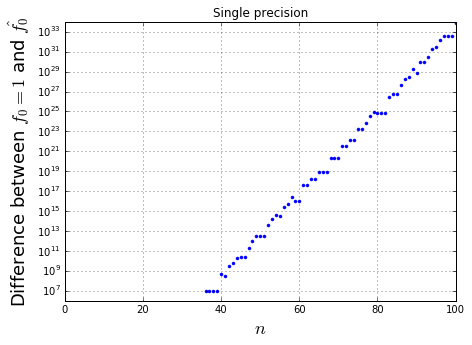

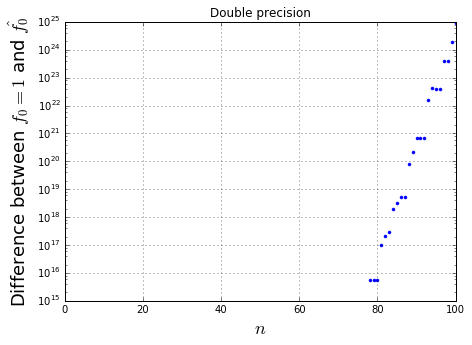

In [16]:
def rfib(n,f):
    if n > len(f)-1:
        raise ValueError('n must be smaller than or equal to len(f)-1')
    a = f[n]
    b = f[n-1]
    while n - 1 > 0:
        a,b = b,a-b
        n -= 1
    return 1-b

f32 = np.float32(fib(100))
f64 = np.float64(fib(100))

nmax32 = 100
nmax64 = 100
r32 = np.arange(2,nmax32+1,1)
r64 = np.arange(2,nmax64+1,1)
fdiff32 = np.zeros(nmax32-1,dtype=np.float32)
fdiff64 = np.zeros(nmax64-1)

for i,j in enumerate(r32):
    fdiff32[i] = np.abs(rfib(j,f32))

for i,j in enumerate(r64):
    fdiff64[i] = np.abs(rfib(j,f64))

fig2 = plt.figure(figsize=(7,5))
plt.plot(r32,fdiff32,'.')
plt.yscale('log')
plt.xlabel(r'$n$',fontsize=18)
plt.ylabel(r'Difference between $f_0 = 1 $ and $\^{f_0}$',fontsize=18)
plt.title('Single precision')
plt.grid()

fig3 = plt.figure(figsize=(7,5))
plt.plot(r64,fdiff64,'.')
plt.yscale('log')
plt.xlabel(r'$n$',fontsize=18)
plt.ylabel(r'Difference between $f_0 = 1$ and $\^{f_0}$',fontsize=18)
plt.title('Double precision')
plt.grid()
plt.show()

For the single-precision case, the absolute difference is 0 until $n=36$, which is just at the point where the threshold of $1/\epsilon_{mach}$ is reached. The log difference then increases in a quasi-linear fashion with $n$. Likewise, in the double-precision case, the absolute difference remains 0 until $n=78$, just at the point where the threshold is reached. In other words, the accuracy for $\hat{f_0}$ is maintained until much later with double precision.

#### Part (c)

The reversed *pib* series is calculated for $n$ from 2 to 100, and the absolute difference bdtween $p_0 = 1$ and $\hat{p_0}$ is plotted in log scale as a function of $n$. The calculations are done in both single and double precisions.

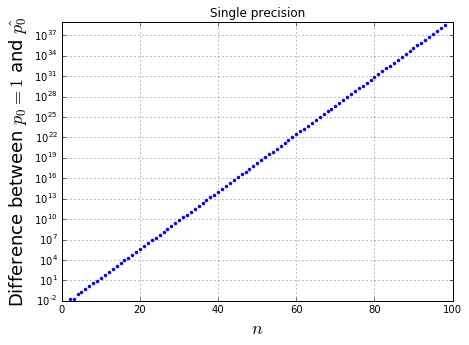

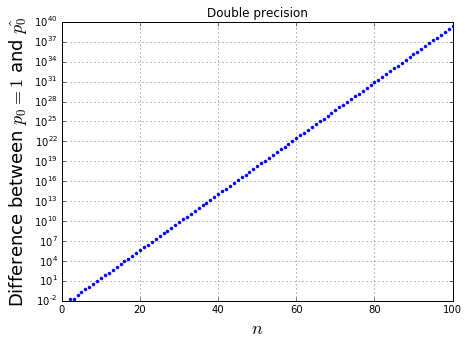

In [17]:
def rpib(n,p):
    if n > len(p)-1:
        raise ValueError('n must be smaller than or equal to len(p)-1')
    a = p[n]
    b = p[n-1]
    while n - 1 > 0:
        a,b = b, a-b
        n -= 1
    return 1-b

p32 = np.float32(pib(100))
p64 = np.float64(pib(100))
pdiff32 = np.zeros(nmax32-1,dtype=np.float32)
pdiff64 = np.zeros(nmax64-1)

for i,j in enumerate(r32):
    pdiff32[i] = np.abs(rpib(j,p32))

for i,j in enumerate(r64):
    pdiff64[i] = np.abs(rpib(j,p64))

fig4 = plt.figure(figsize=(7,5))
plt.plot(r32,pdiff32,'.')
plt.xlabel(r'$n$',fontsize=18)
plt.ylabel(r'Difference between $p_0 = 1 $ and $\^{p_0}$',fontsize=18)
plt.yscale('log')
plt.title('Single precision')
plt.grid()

fig5 = plt.figure(figsize=(7,5))
plt.plot(r64,pdiff64,'.')
plt.xlabel(r'$n$',fontsize=18)
plt.ylabel(r'Difference between $p_0 = 1$ and $\^{p_0}$',fontsize=18)
plt.yscale('log')
plt.title('Double precision')
plt.grid()
plt.show()

Unlike the *fibonacci* case, here accuracy is already lost even for $n=2$. Meanwhile, the log differences are almost identical in magnitude for single and double precision, and both increase linearly with $n$. Namely, using double precision would not improve the results.

If floating numbers (not cast from integers) are involved in the calculation, the *pib* scenario may be more typical as errors start to propagate through in the early stage.

## Extra Credit

Find and explain the cause of large errors in lecture slide "Unexpected Twist", and implement a new version that is more accurate.

### Solution 
The errors shown in the example is not due to floating point calculation. It is in fact due to integer overflow. We can change the input to float to avoid large errors.

In [18]:
import math

def exp_taylor(x, n) :
    return sum([(1.*x)**i/math.factorial(i) for i in np.arange(1, n)]) + 1. 
    # note that x is multiplied by 1. to convert it to a float

terms = 100
x = 5
print "rel err for exp(%.f) is %.2f%%" % (x, (np.exp(x) - exp_taylor(x, terms))/np.exp(x)*100)
x = -5
print "rel err for exp(%.f) is %.2f%%" % (x, (np.exp(x) - exp_taylor(x, terms))/np.exp(x)*100)

print "exp_taylor(%.f) = %f, exp(%.f) = %f" % (x, exp_taylor(-5, terms), x, np.exp(-5))

rel err for exp(5) is -0.00%
rel err for exp(-5) is 0.00%
exp_taylor(-5) = 0.006738, exp(-5) = 0.006738
